<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-this-notebook-does" data-toc-modified-id="What-this-notebook-does-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What this notebook does</a></span></li><li><span><a href="#Usual-Firedrake-preliminaries" data-toc-modified-id="Usual-Firedrake-preliminaries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Usual Firedrake preliminaries</a></span></li><li><span><a href="#Solving-the-problem-using-a-standard-Galerkin-method" data-toc-modified-id="Solving-the-problem-using-a-standard-Galerkin-method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Solving the problem using a standard Galerkin method</a></span></li><li><span><a href="#A-stable-solution,-via-artificial-diffusion" data-toc-modified-id="A-stable-solution,-via-artificial-diffusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A stable solution, via artificial diffusion</a></span><ul class="toc-item"><li><span><a href="#Upwinding:-the-formulation" data-toc-modified-id="Upwinding:-the-formulation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Upwinding: the formulation</a></span></li></ul></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Exercises</a></span></li></ul></div>

# Example 4: Convection-diffusion problems in 1D

[Niall Madden](https://www.niallmadden.ie/) _Dec 2024_

This notebook discusses how to solve a problem with odd-order derivatives, specifically a second-order convection-diffusion problem. 
We also show how to implement a very simple _artificial diffusion_ method.


## What this notebook does 
The generic form of the ODE we'll consider is 
$$\mathcal{L}(u) := -\varepsilon u''(x) + c(x)u'(x) + r(x)u(x)= f(x) \text{ on } \Omega:= (0,1),$$
with the boundary conditions conditions: $u(0)=u(1)=0$.

The specific example we'll study is
$$-\varepsilon u''(x) - u'(x) =1  \text{ on } \Omega:= (0,1).$$
The true solution is
$$u(x) = \frac{1-e^{-x/\varepsilon}}{1-e^{-1/\varepsilon}} - x.$$
This test problem is considered in many papers. Of particular note is https://epubs.siam.org/doi/10.1137/090757344



## Usual Firedrake preliminaries

In [1]:
import os
if "OMP_NUM_THREADS" not in os.environ:
    os.environ["OMP_NUM_THREADS"] = "1"  

In [2]:
from firedrake import *
import numpy as np
# %matplotlib notebook # use if you would like to zoom, etc.
import matplotlib.pyplot as plt

##  Solving the problem using a standard Galerkin method

The variational formulation for the problem above is 
$$\varepsilon (u',v') + (c u',v) = (1,v).$$
 

If you experiment with the code below, you should find that, for some choices of $\varepsilon$ and $N$, you observe oscillations, for others, you do not. For example, $(\varepsilon,N)=(0.1, 32)$, the solution appears stable, but not when $(\varepsilon,N)=(0.01, 32)$.

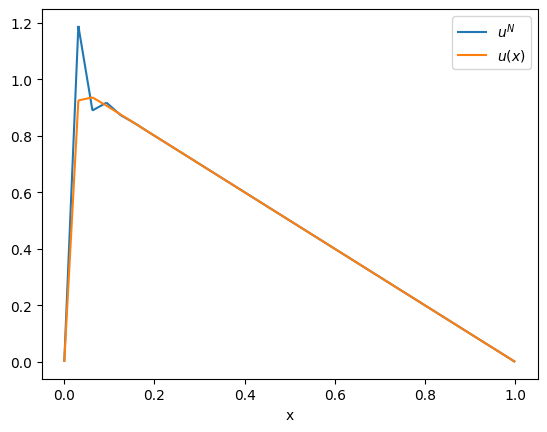

In [3]:
epsilon = 1.0e-2 # Take care with smaller values
c = -1 # convection coefficient 

N = 32
u_true = lambda x : (1-exp(-x/epsilon))/(1-exp(-1/epsilon)) -x 

mesh1D = UnitIntervalMesh(N)
Ue = FiniteElement("CG", mesh1D.ufl_cell(), 1)
V = FunctionSpace(mesh1D, Ue)
x = SpatialCoordinate(mesh1D)

u = TrialFunction(V)
v = TestFunction(V)
a = epsilon*inner(grad(u),grad(v))*dx + c*u.dx(0)*v*dx
L = Constant(1)*v*dx   

BC = DirichletBC(V, 0.0, "on_boundary")
    
uN = Function(V)
solve(a == L, uN, bcs=BC)

uE = Function(V); uE.interpolate(u_true(x[0]))  

fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^N$') # numerical
plot(uE, axes=axes, label='$u(x)$') # true
plt.xlabel("x")
plt.legend()

Notice that the solution varies rapidly near $x=0$. This is a very simple example of a _boundary layer_.

## A stable solution, via artificial diffusion

There are numerous approaches to modifying the approach in order to get a more satisfactory solution. One approach that is not feasible is to choose $N$ such that $N/\varepsilon$ is $\mathcal{O}(1)$. This is because one may be interested in very. very small values of $\varepsilon$. 

More feasible would be to take a specialised non-uniform mesh, which is very fine in the region of the boundary later. We'll consider that in a later notebook.

An alternative approach is to use a difference choice of test functions. Specifically, rather than testing against $v$, we shall test against $v+ \delta c v'$, where $\delta$ is a parameter that one chooses. In this example, $\delta=h/2$ shall suffice.

This approach is a very simple example of _streamline diffusion_ or _streamline upwind Petrov-Galerkin_ (SUPG), or simply (in 1D) as _Upwinding_. As we shall see, it is not especially impressive in 1D: it gives a solution that is stable, but not very accurate. But it is useful in higher dimensions.

### Upwinding: the formulation

Our variational formulation becomes
$$ \varepsilon\big(u',  (v + \delta c v')'\big) + \big(c u',  (v + \delta c v')\big) = \big(f,v+\delta cv' \big)$$
But in our examples $v$ belongs to the space of piecewise linear polynomials on our mesh. Therefore $(u,v'')=0$ for any $u$. So now we have 
$$ \varepsilon\big(u',  v '\big) + \big(c u',  (v + \delta c v')\big) = \big(f,v+\delta cv' \big),$$
which is what we implement below.

However, note that (for constant $c$), this could also be written as 
$$ (\varepsilon + \delta c^2) \big(u',  v '\big) + \big(c u',  v\big) = \big(f,v+\delta cv' \big).$$
That is, it is as though we changed the diffusion coefficient from $\varepsilon$ to the much larger expression $\varepsilon + \delta c^2$. So this is an _artificial diffusion_ method.

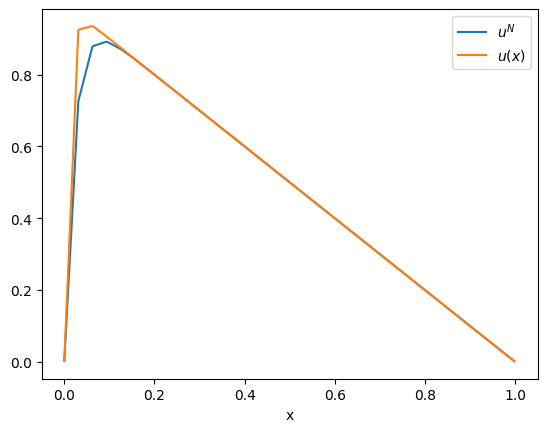

In [4]:
Ue = FiniteElement("CG", mesh1D.ufl_cell(), 1)
V = FunctionSpace(mesh1D, Ue)
x = SpatialCoordinate(mesh1D)

u = TrialFunction(V)
v = TestFunction(V)
h = 1.0/N
delta = h/2.0
a = epsilon*(u.dx(0)*v.dx(0))*dx + c*u.dx(0)*(v+c*delta*v.dx(0))*dx
L = Constant(1)*(v+c*delta*v.dx(0))*dx

BC = DirichletBC(V, 0.0, "on_boundary")
    
uN = Function(V)
solve(a == L, uN, bcs=BC)

uE = Function(V); uE.interpolate(u_true(x[0]))  

fig, axes = plt.subplots()
plot(uN, axes=axes, label='$u^N$') # numerical
plot(uE, axes=axes, label='$u(x)$') # true
plt.xlabel("x")
plt.legend()

Notice that, in the above plot, $u^N$ no longer exhibits oscillations, but the layer is much less sharp than we should be. These are both effects of the artificial diffusion that has been introduced.

##  Exercises

1. Determine, computationally. the order of convergence of this method.
2. Modify the streamline diffusion approach so that $P^2$ elements are used.